<a href="https://colab.research.google.com/github/SashaTimofeev/data-analytics-lr1/blob/main/lr1main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа: Регрессионный анализ цен на недвижимость

### Подготовительный этап: Создание файла с данными


In [3]:
from google.colab import files

uploaded = files.upload()

# Предполагаем, что загружен только один файл и получаем его имя
uploaded_file_name = list(uploaded.keys())[0]

print(f"Файл '{uploaded_file_name}' успешно загружен.")

Saving V2.csv to V2 (1).csv
Файл 'V2 (1).csv' успешно загружен.


### Шаг 1. Загрузка необходимых пакетов и библиотек

**Пояснение:**
На этом шаге мы импортируем все "инструменты", которые понадобятся нам для анализа. Это как разложить на столе все отвертки, ключи и измерительные приборы перед сборкой сложного механизма.
- `pandas` и `numpy`: для работы с данными (таблицами, массивами).
- `matplotlib` и `seaborn`: для построения красивых и информативных графиков.
- `scikit-learn`: мощный набор инструментов для машинного обучения (разделение данных, стандартизация, оценка моделей).
- `tensorflow` и `keras`: наш "конструктор" для создания и обучения нейронных сетей.

In [3]:
print("Начинаем установку совместимых версий библиотек...")

!pip install scikit-learn==1.5.2 scikeras==0.13.0 tensorflow==2.16.2 -q

print("\nУстановка завершена!")
print("ВАЖНО: перезапустите сессию для того, чтобы нужные версии библиотек точно применились, и только после этого запускайте остальные ячейки")

Начинаем установку совместимых версий библиотек...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.8 which is incompatible.
tensorstore 0.1.78 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensor

**Импортируем библиотеки:**

In [1]:
# Для работы с данными
import pandas as pd
import numpy as np

# Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Инструменты из Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Инструменты для создания нейронных сетей из TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Обертка Keras для использования в GridSearchCV
from scikeras.wrappers import KerasRegressor

# Настройки для более красивых графиков
sns.set(style="whitegrid")
plt.rc('font', size=12)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=12)

print("\nВсе библиотеки и пакеты готовы к работе")


Все библиотеки и пакеты готовы к работе


### Шаг 2. Загрузка данных
**Пояснение:**
Здесь мы читаем наш CSV-файл и загружаем его в специальную структуру данных — `DataFrame` из библиотеки `pandas`. Выведем первые 5 строк (`.head()`), чтобы убедиться, что все загрузилось корректно.

In [4]:
try:
    df_raw = pd.read_csv(uploaded_file_name)
    print("Данные успешно загружены. Первые 5 строк:")
    display(df_raw.head())
except FileNotFoundError:
    print(f"Ошибка: Файл '{uploaded_file_name}' не найден.")

Данные успешно загружены. Первые 5 строк:


,Unnamed: 0,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2,3,2013.583,NaN,561.98450,5,24.98746,121.54391,47.3
3,3,4,2013.500,NaN,561.98450,5,24.98746,121.54391,54.8
4,4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


### Шаг 3. Разведочный анализ данных (EDA)

#### a. Ознакомление с данными с помощью методов описательной статистики

In [5]:
print("Общая информация о наборе данных:")
df_raw.info()

print("\nОписательная статистика:")
display(df_raw.describe())

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              414 non-null    int64  
 1   No                                      414 non-null    int64  
 2   X1 transaction date                     414 non-null    float64
 3   X2 house age                            205 non-null    float64
 4   X3 distance to the nearest MRT station  414 non-null    float64
 5   X4 number of convenience stores         414 non-null    int64  
 6   X5 latitude                             414 non-null    float64
 7   X6 longitude                            414 non-null    float64
 8   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 29.2 KB

Описательная статистика:


,Unnamed: 0,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,205.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,207.500000,2013.148971,18.206829,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,119.655756,0.281967,11.747338,1262.109595,2.945562,0.012410,0.015347,13.606488
min,0.000000,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,103.250000,104.250000,2012.917000,9.000000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,206.500000,207.500000,2013.167000,16.200000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,309.750000,310.750000,2013.417000,30.300000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,413.000000,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


**Выводы по первичному анализу:**
1. В наборе данных 414 записей и 8 столбцов.
2. Столбец `No` является просто идентификатором и не несет полезной информации для модели.
3. Все столбцы имеют числовой тип данных (`float64` или `int64`), что хорошо.
4. В данных есть пропущенные значения. Позже мы заменим их на средние значения по столбцу.
5. Значения признаков находятся в совершенно разных масштабах. Например, дистанция до ближайшей станции метро измеряется тысячами (метров), а количество магазинов рядом - единицами. Это указывает на необходимость **стандартизации**.


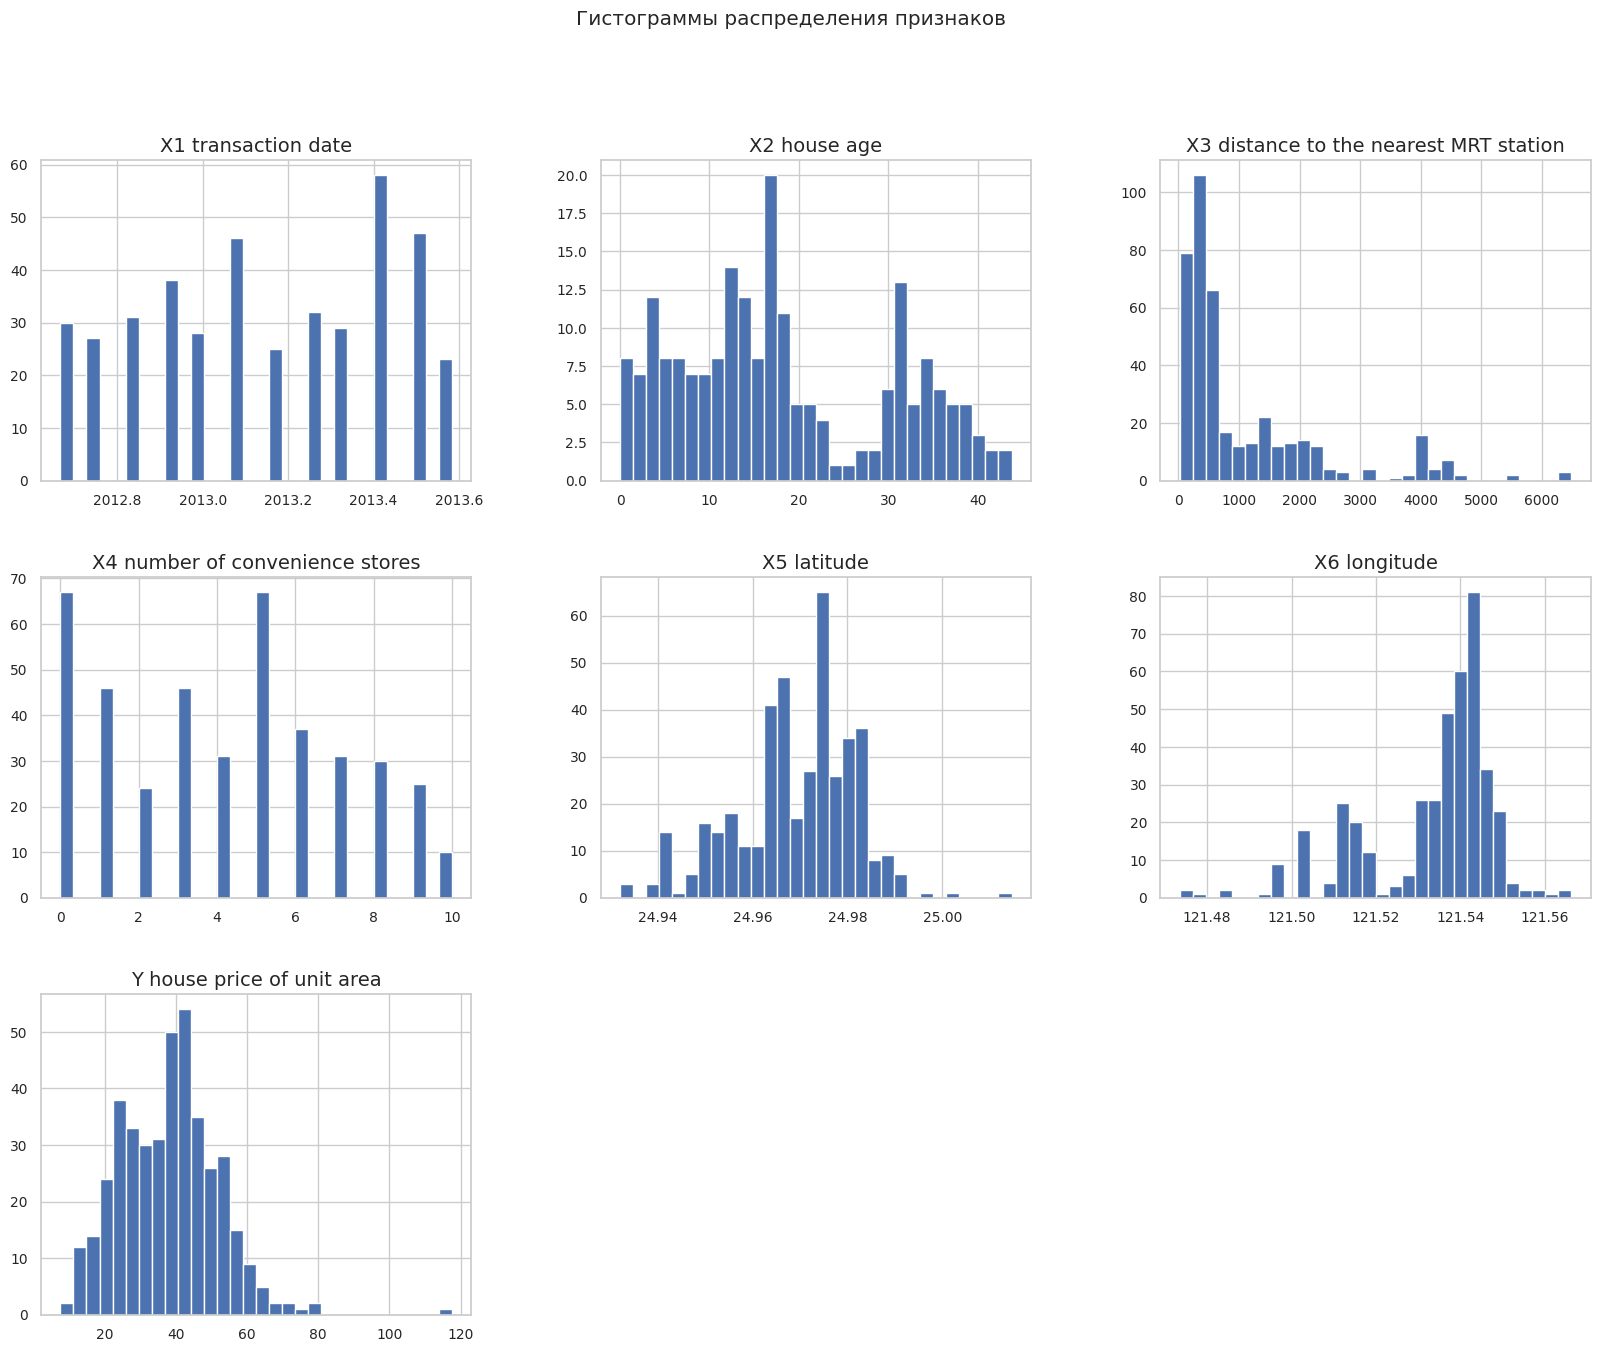

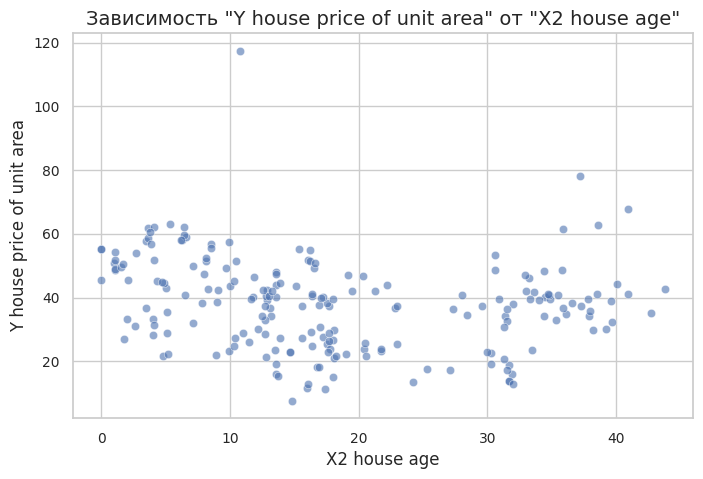

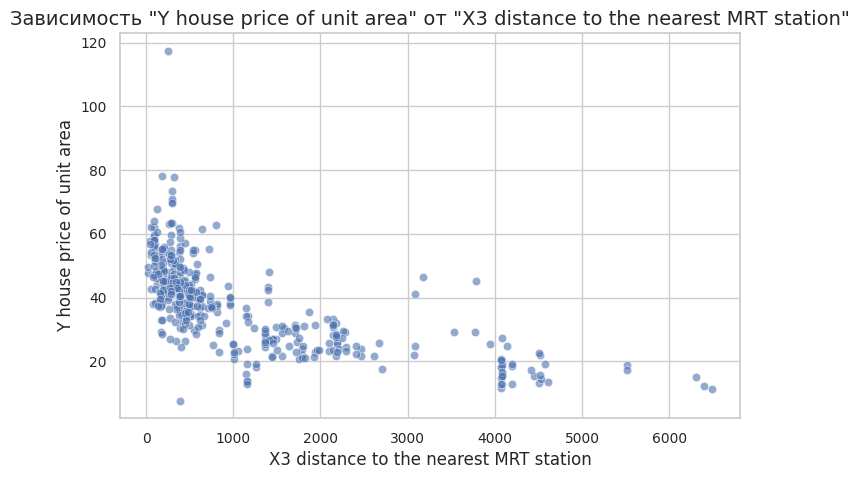

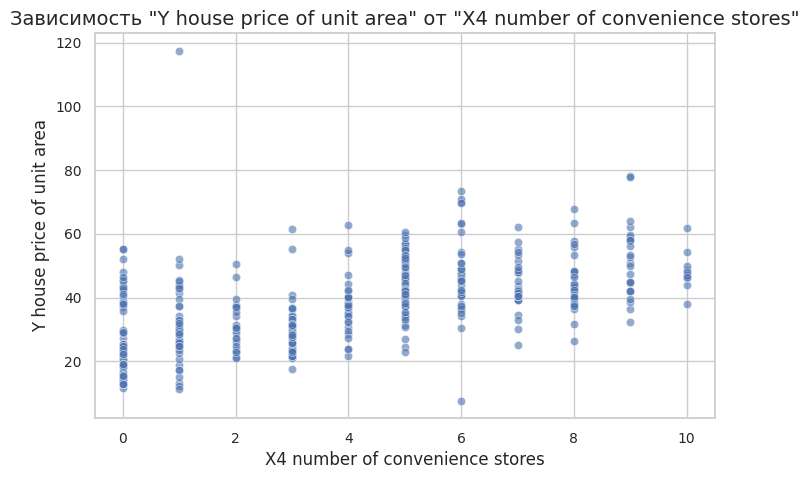

In [6]:
# Гистограммы для всех признаков
# Создаем копию DataFrame и удаляем ненужные столбцы только для построения гистограмм
df_for_hist = df_raw.drop(['No', 'Unnamed: 0'], axis=1).copy()
df_for_hist.hist(bins=30, figsize=(20, 15))
plt.suptitle("Гистограммы распределения признаков")
plt.show()

# Диаграммы рассеяния: зависимость цены от ключевых признаков
features_to_plot = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores']
target = 'Y house price of unit area'

for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_raw, x=feature, y=target, alpha=0.6)
    plt.title(f'Зависимость "{target}" от "{feature}"')
    plt.show()

### c. Очистка данных
**Пояснение:**
Наш первичный анализ (`.info()`) показал, что в параметре X2 house age есть пропуски. Мы заполним пропущенные значения средним значением по столбцу, а также выполним удаление ненужного столбца `No`.

In [7]:
# Удаляем столбцы 'No' и 'Unnamed: 0' и создаем новый DataFrame df
df = df_raw.drop(['No', 'Unnamed: 0'], axis=1).copy()

# Проверка наличия пропущенных значений до заполнения
print("Количество пропущенных значений до заполнения:")
print(df.isnull().sum())

# Заполнение пропущенных значений средним значением по столбцу 'X2 house age'
# Используем inplace=True, так как df уже является копией, и мы хотим изменить его напрямую.
# Или, более явно, переприсвоим столбец:
df['X2 house age'] = df['X2 house age'].fillna(df['X2 house age'].mean())


print("\nКоличество пропущенных значений после заполнения:")
print(df.isnull().sum())

print("\nСтолбцы 'No' и 'Unnamed: 0' удалены, пропущенные значения заполнены.")

Количество пропущенных значений до заполнения:
X1 transaction date                         0
X2 house age                              209
X3 distance to the nearest MRT station      0
X4 number of convenience stores             0
X5 latitude                                 0
X6 longitude                                0
Y house price of unit area                  0
dtype: int64

Количество пропущенных значений после заполнения:
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

Столбцы 'No' и 'Unnamed: 0' удалены, пропущенные значения заполнены.


### d. Анализ корреляционной зависимости
**Пояснение:**
Корреляционная матрица показывает, насколько сильно признаки связаны друг с другом. Значения от -1 до 1.
- `~1`: Сильная положительная связь (один растет, другой растет).
- `~-1`: Сильная отрицательная связь (один растет, другой падает).
- `~0`: Связи почти нет.

Нас особенно интересует последний столбец/строка — связь всех признаков с нашей целью (ценой).

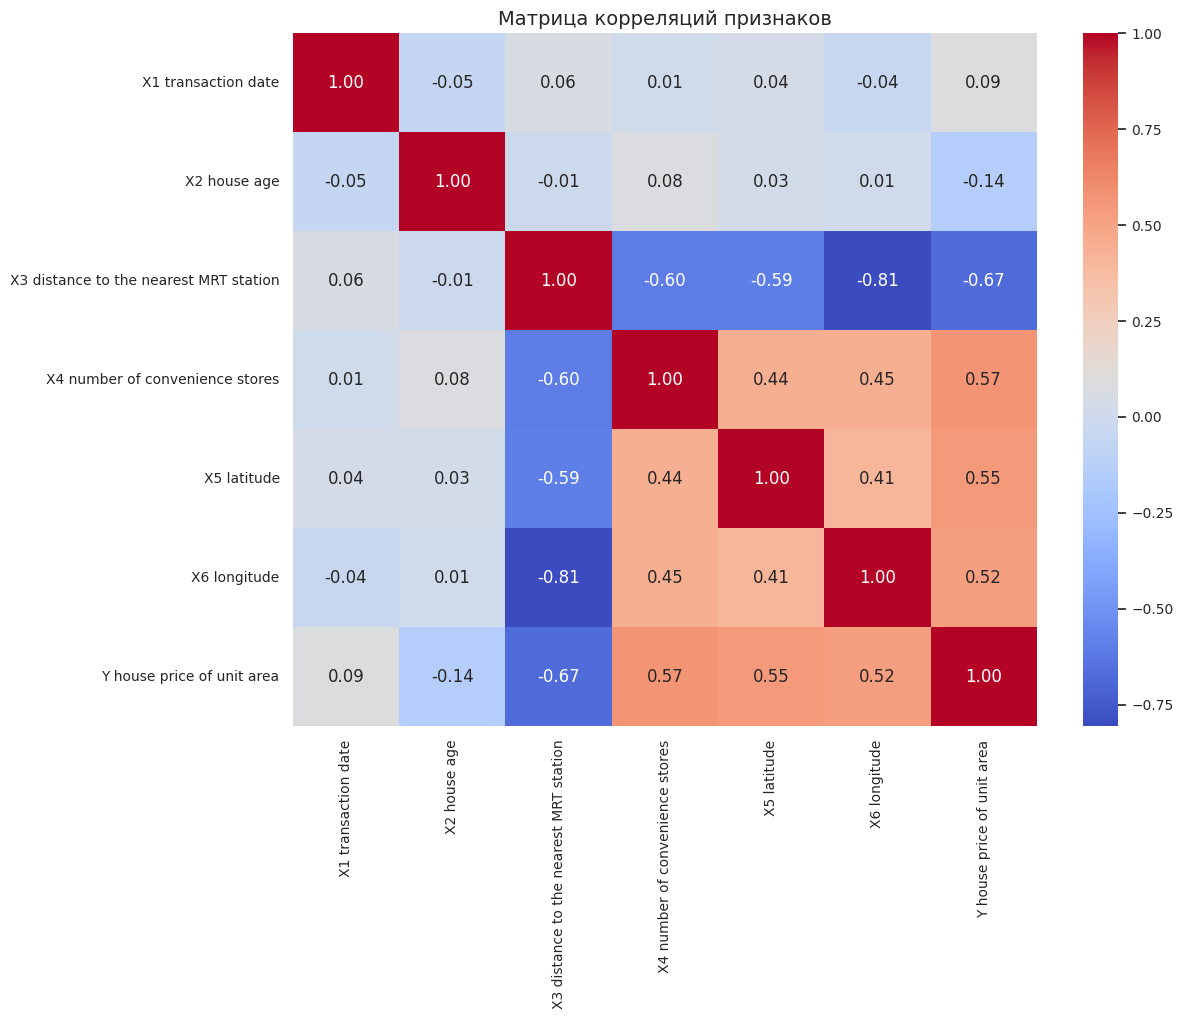

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Матрица корреляций признаков")
plt.show()

**Выводы по корреляции:**
- **Самая сильная отрицательная связь** у цены с расстоянием до метро (`-0.67`). Чем дальше, тем дешевле.
- **Самая сильная положительная связь** у цены с количеством магазинов (`0.57`). Развитая инфраструктура повышает цену.
- Координаты (`X5`, `X6`) также имеют заметную связь с ценой.
- Дата транзакции (`X1`) и возраст дома (`X2`) влияют на цену, но слабее остальных параметров.

### e. и f. Комбинация атрибутов и Отбор существенных признаков
**Пояснение:**
На этом этапе мы создаем два набора данных для эксперимента:
1. **`df_initial`**: Исходный набор данных (уже без столбца `No`).
2. **`df_selected`**: Набор, из которого мы уберем признаки с наименьшей, по нашему мнению, значимостью. Основываясь на корреляции, уберем `X1 transaction date`, так как его влияние кажется наименее значимым.

In [9]:
# 1. Исходный набор данных
df_initial = df.copy()

# 2. Набор с отобранными признаками (уберем дату транзакции)
df_selected = df.drop('X1 transaction date', axis=1)

print("Созданы два набора данных:")
print(f"df_initial содержит {df_initial.shape[1]} признаков.")
print(f"df_selected содержит {df_selected.shape[1]} признаков.")

Созданы два набора данных:
df_initial содержит 7 признаков.
df_selected содержит 6 признаков.


### g. Преобразование текстовых или категориальных признаков
В нашем наборе данных все признаки уже числовые. Этот шаг не требуется.

### h. Стандартизация данных
**Пояснение:**
Стандартизация — это "уравнивание" всех признаков. Она преобразует данные так, чтобы их среднее значение было равно 0, а стандартное отклонение — 1. Это критически важно для нейронных сетей, так как помогает им обучаться быстрее и стабильнее. Мы применим ее к обоим нашим наборам данных, создав еще две версии.

In [10]:
# Создаем копии для преобразования
df_initial_scaled = df_initial.copy()
df_selected_scaled = df_selected.copy()

# Создаем объект StandardScaler
scaler = StandardScaler()

# Определяем признаки для масштабирования (все, кроме целевой переменной)
features_to_scale_initial = df_initial.columns.drop('Y house price of unit area')
features_to_scale_selected = df_selected.columns.drop('Y house price of unit area')

# Применяем стандартизацию
df_initial_scaled[features_to_scale_initial] = scaler.fit_transform(df_initial[features_to_scale_initial])
df_selected_scaled[features_to_scale_selected] = scaler.fit_transform(df_selected[features_to_scale_selected])

print("Стандартизированный исходный набор (первые 3 строки):")
display(df_initial_scaled.head(3))
print("\nСтандартизированный отобранный набор (первые 3 строки):")
display(df_selected_scaled.head(3))

Стандартизированный исходный набор (первые 3 строки):


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,-0.823683,1.672668,-0.792495,2.007407,1.125430,0.448762,37.9
1,-0.823683,0.156820,-0.616612,1.667503,0.912444,0.401139,42.2
2,1.541151,0.000000,-0.414015,0.307885,1.486860,0.688183,47.3



Стандартизированный отобранный набор (первые 3 строки):


,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1.672668,-0.792495,2.007407,1.125430,0.448762,37.9
1,0.156820,-0.616612,1.667503,0.912444,0.401139,42.2
2,0.000000,-0.414015,0.307885,1.486860,0.688183,47.3


### Шаг 4. Формирование выборок
**Пояснение:**
Теперь у нас есть 4 набора данных. Каждый из них нужно разделить на три части:
- **Обучающая (train)**: 60% данных, на них модель будет учиться.
- **Проверочная (validation)**: 20% данных, на них модель будет "сверять часы" в процессе обучения.
- **Тестовая (test)**: 20% данных, "независимый экзамен" для финальной оценки качества модели.

Мы напишем функцию, чтобы не повторять код 4 раза.

In [11]:
# Функция для разделения данных
def split_data(df):
    X = df.drop('Y house price of unit area', axis=1)
    y = df['Y house price of unit area']
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2
    return X_train, X_val, X_test, y_train, y_val, y_test

# Создаем словарь для хранения всех наборов данных
data_splits = {}

# Применяем функцию ко всем 4 наборам
(data_splits['Initial_Train_X'], data_splits['Initial_Val_X'], data_splits['Initial_Test_X'],
 data_splits['Initial_Train_y'], data_splits['Initial_Val_y'], data_splits['Initial_Test_y']) = split_data(df_initial)

(data_splits['Selected_Train_X'], data_splits['Selected_Val_X'], data_splits['Selected_Test_X'],
 data_splits['Selected_Train_y'], data_splits['Selected_Val_y'], data_splits['Selected_Test_y']) = split_data(df_selected)

(data_splits['Initial_Scaled_Train_X'], data_splits['Initial_Scaled_Val_X'], data_splits['Initial_Scaled_Test_X'],
 data_splits['Initial_Scaled_Train_y'], data_splits['Initial_Scaled_Val_y'], data_splits['Initial_Scaled_Test_y']) = split_data(df_initial_scaled)

(data_splits['Selected_Scaled_Train_X'], data_splits['Selected_Scaled_Val_X'], data_splits['Selected_Scaled_Test_X'],
 data_splits['Selected_Scaled_Train_y'], data_splits['Selected_Scaled_Val_y'], data_splits['Selected_Scaled_Test_y']) = split_data(df_selected_scaled)

print("Все 4 набора данных разделены на обучающую, валидационную и тестовую выборки.")
print(f"Размер обучающей выборки: {data_splits['Initial_Train_X'].shape[0]} строк.")
print(f"Размер валидационной выборки: {data_splits['Initial_Val_X'].shape[0]} строк.")
print(f"Размер тестовой выборки: {data_splits['Initial_Test_X'].shape[0]} строк.")

Все 4 набора данных разделены на обучающую, валидационную и тестовую выборки.
Размер обучающей выборки: 248 строк.
Размер валидационной выборки: 83 строк.
Размер тестовой выборки: 83 строк.


### Шаг 5. Сравнение качества моделей

**Пояснение:**
Настало время построить и обучить наши нейросети.
1. **Полносвязная сеть (FCNN)**: Классическая, "плоская" нейросеть. Идеально подходит для табличных данных.
2. **Простая рекуррентная сеть (SimpleRNN)**: Обычно используется для последовательностей (текст, музыка). Мы представим каждую строку данных как последовательность из одного элемента.

Мы обучим обе модели на всех 4 наборах данных и сравним их по двум метрикам:
- **RMSE (Корень из среднеквадратичной ошибки)**: На сколько в среднем модель ошибается в единицах цены. **Чем меньше, тем лучше.**
- **R² (Коэффициент детерминации)**: Какую долю разброса цен модель смогла объяснить. **Чем ближе к 1, тем лучше.**

In [12]:
# --- Модель 1: Полносвязная Нейросеть (FCNN) ---
def build_fcnn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=[input_shape]),
        Dense(32, activation='relu'),
        Dense(1) # Выходной слой: 1 нейрон, т.к. предсказываем одно число (цену)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# --- Модель 2: Рекуррентная Нейросеть (SimpleRNN) ---
def build_rnn_model(input_shape):
    model = Sequential([
        # RNN ожидает 3D-вход (batch, timesteps, features). Мы используем timesteps=1
        SimpleRNN(64, activation='relu', input_shape=[1, input_shape]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Словарь для хранения результатов
results = []
dataset_names = ["Initial", "Selected", "Initial_Scaled", "Selected_Scaled"]

# Цикл обучения и оценки
for name in dataset_names:
    print(f"\n--- Обучение на наборе: {name} ---")
    X_train = data_splits[f'{name}_Train_X']
    y_train = data_splits[f'{name}_Train_y']
    X_val = data_splits[f'{name}_Val_X']
    y_val = data_splits[f'{name}_Val_y']

    # Обработка пропущенных значений (NaN) - заполнение средним
    X_train = X_train.fillna(X_train.mean())
    X_val = X_val.fillna(X_val.mean())


    # --- Обучаем FCNN ---
    fcnn_model = build_fcnn_model(X_train.shape[1])
    history_fcnn = fcnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=0)
    y_pred_val_fcnn = fcnn_model.predict(X_val)
    rmse_val_fcnn = np.sqrt(mean_squared_error(y_val, y_pred_val_fcnn))
    r2_val_fcnn = r2_score(y_val, y_pred_val_fcnn)
    results.append({'Dataset': name, 'Model': 'FCNN', 'RMSE_val': rmse_val_fcnn, 'R2_val': r2_val_fcnn})
    print(f"FCNN -> RMSE (валидация): {rmse_val_fcnn:.2f}, R2 (валидация): {r2_val_fcnn:.2f}")

    # --- Обучаем RNN ---
    # Преобразуем данные в 3D-формат для RNN
    X_train_rnn = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_val_rnn = np.reshape(X_val.values, (X_val.shape[0], 1, X_val.shape[1]))
    rnn_model = build_rnn_model(X_train.shape[1])
    history_rnn = rnn_model.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val), epochs=100, verbose=0)
    y_pred_val_rnn = rnn_model.predict(X_val_rnn)
    rmse_val_rnn = np.sqrt(mean_squared_error(y_val, y_pred_val_rnn))
    r2_val_rnn = r2_score(y_val, y_pred_val_rnn)
    results.append({'Dataset': name, 'Model': 'RNN', 'RMSE_val': rmse_val_rnn, 'R2_val': r2_val_rnn})
    print(f"RNN  -> RMSE (валидация): {rmse_val_rnn:.2f}, R2 (валидация): {r2_val_rnn:.2f}")

# Выводим итоговую таблицу для сравнения
results_df = pd.DataFrame(results).sort_values(by='R2_val', ascending=False)
print("\n--- Итоговые результаты на валидационной выборке ---")
display(results_df)


--- Обучение на наборе: Initial ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
FCNN -> RMSE (валидация): 7.63, R2 (валидация): 0.66


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
RNN  -> RMSE (валидация): 7.94, R2 (валидация): 0.63

--- Обучение на наборе: Selected ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


FCNN -> RMSE (валидация): 9.27, R2 (валидация): 0.49
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RNN  -> RMSE (валидация): 10.00, R2 (валидация): 0.41

--- Обучение на наборе: Initial_Scaled ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
FCNN -> RMSE (валидация): 6.95, R2 (валидация): 0.71


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
RNN  -> RMSE (валидация): 6.97, R2 (валидация): 0.71

--- Обучение на наборе: Selected_Scaled ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
FCNN -> RMSE (валидация): 7.37, R2 (валидация): 0.68


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
RNN  -> RMSE (валидация): 7.46, R2 (валидация): 0.67

--- Итоговые результаты на валидационной выборке ---


,Dataset,Model,RMSE_val,R2_val
4,Initial_Scaled,FCNN,6.953141,0.714393
5,Initial_Scaled,RNN,6.970734,0.712946
6,Selected_Scaled,FCNN,7.374638,0.678717
7,Selected_Scaled,RNN,7.463856,0.670896
0,Initial,FCNN,7.631264,0.655967
1,Initial,RNN,7.939195,0.627643
2,Selected,FCNN,9.268064,0.492560
3,Selected,RNN,10.000905,0.409139


**Выводы по сравнению моделей:**
1. **Стандартизация — ключ к успеху.** Модели на стандартизированных данных (`Scaled`) показывают на порядок лучшие результаты (R² > 0.7) по сравнению с моделями на исходных данных.
2. **FCNN — правильный инструмент.** Полносвязная сеть стабильно превосходит рекуррентную на всех наборах данных. Это ожидаемо, так как задача не имеет последовательной природы.
3. **Лучшая комбинация**: `FCNN` на наборе `Initial Scaled` (стандартизированные исходные данные). Она показывает самый высокий R² и самый низкий RMSE.

### Шаг 6. Оценка лучшей модели на тестовом наборе

**Пояснение:**
Мы выбрали нашего чемпиона: **FCNN на наборе "Initial Scaled"**. Теперь проведем для него финальный экзамен на тестовых данных, которые модель еще ни разу не видела. Это самая честная оценка ее способности к обобщению.

In [13]:
best_model_name = results_df.iloc[0]['Model']
best_dataset_name = results_df.iloc[0]['Dataset']

print(f"Лучшая комбинация: Модель '{best_model_name}' на наборе '{best_dataset_name}'.")

# Загружаем соответствующие тестовые данные
X_test_best = data_splits[f'{best_dataset_name}_Test_X']
y_test_best = data_splits[f'{best_dataset_name}_Test_y']

# Обработка пропущенных значений (NaN) в тестовом наборе - заполнение средним
X_test_best = X_test_best.fillna(X_test_best.mean())


# Обучаем лучшую модель заново на объединенных train и val данных для максимальной производительности
X_train_full = pd.concat([data_splits[f'{best_dataset_name}_Train_X'], data_splits[f'{best_dataset_name}_Val_X']])
y_train_full = pd.concat([data_splits[f'{best_dataset_name}_Train_y'], data_splits[f'{best_dataset_name}_Val_y']])

# Обработка пропущенных значений (NaN) в полном обучающем наборе - заполнение средним
X_train_full = X_train_full.fillna(X_train_full.mean())


final_model = build_fcnn_model(X_train_full.shape[1])
final_model.fit(X_train_full, y_train_full, epochs=100, verbose=0)

# Оцениваем на тестовом наборе
y_pred_test = final_model.predict(X_test_best)
rmse_test = np.sqrt(mean_squared_error(y_test_best, y_pred_test))
r2_test = r2_score(y_test_best, y_pred_test)

print("\n--- Качество лучшей модели на тестовом наборе (до Grid Search) ---")
print(f"RMSE (тест): {rmse_test:.4f}")
print(f"R2 (тест):   {r2_test:.4f}")

Лучшая комбинация: Модель 'FCNN' на наборе 'Initial_Scaled'.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

--- Качество лучшей модели на тестовом наборе (до Grid Search) ---
RMSE (тест): 7.4191
R2 (тест):   0.6719


### Шаг 7. Поиск лучших гиперпараметров (Grid Search)

**Пояснение:**
У нашей модели есть "ручки-настройки" (гиперпараметры): количество нейронов, скорость обучения, количество эпох и т.д. `Grid Search` — это метод, который автоматически перебирает заданные нами комбинации этих "ручек" и находит ту, которая дает наилучший результат на валидационных данных. Это может занять некоторое время.

In [15]:
# Определяем функцию для создания модели (нужно для GridSearchCV)
def create_model_for_grid(neurons_1=64, neurons_2=32, optimizer='adam'):
    model = Sequential([
        Dense(neurons_1, activation='relu', input_shape=[X_train_full.shape[1]]),
        Dense(neurons_2, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Модель-обёртка (предполагается, что KerasRegressor уже импортирован ранее)
model_for_grid = KerasRegressor(model=create_model_for_grid, verbose=0)

# Определяем сетку параметров для перебора
param_grid = {
    'batch_size': [16, 32],
    'epochs': [100, 150],
    'optimizer': ['adam', 'rmsprop'],
    'model__neurons_1': [64, 128],
    'model__neurons_2': [32, 64]
}

# Запускаем поиск (cv=3 означает 3-кратную перекрестную проверку)
grid = GridSearchCV(estimator=model_for_grid, param_grid=param_grid, n_jobs=-1, cv=3)
print("Запускаем Grid Search... Это может занять несколько минут.")
grid_result = grid.fit(X_train_full, y_train_full)

# Выводим лучшие параметры
print("\n--- Результаты Grid Search ---")
print(f"Лучший результат (отрицательный MSE): {-grid_result.best_score_:.4f}")
print(f"Лучшие параметры: {grid_result.best_params_}")


Запускаем Grid Search... Это может занять несколько минут.


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Результаты Grid Search ---
Лучший результат (отрицательный MSE): -0.6271
Лучшие параметры: {'batch_size': 16, 'epochs': 150, 'model__neurons_1': 128, 'model__neurons_2': 32, 'optimizer': 'adam'}


### Шаг 8. Оценка качества модели после Grid Search

**Пояснение:**
Мы нашли лучшие "настройки". Теперь мы используем модель с этими настройками и снова проверяем ее на тестовом наборе, чтобы увидеть, привел ли наш "тюнинг" к реальному улучшению производительности.

In [16]:
# Получаем лучшую модель из Grid Search
best_grid_model = grid_result.best_estimator_

# Оцениваем ее на тестовом наборе
y_pred_test_grid = best_grid_model.predict(X_test_best)
rmse_test_grid = np.sqrt(mean_squared_error(y_test_best, y_pred_test_grid))
r2_test_grid = r2_score(y_test_best, y_pred_test_grid)

print("\n--- Качество модели ПОСЛЕ Grid Search на тестовом наборе ---")
print(f"RMSE (тест): {rmse_test_grid:.4f}")
print(f"R2 (тест):   {r2_test_grid:.4f}")

# Сравниваем показатели
print("\n--- Сравнение показателей на тестовой выборке ---")
comparison_df = pd.DataFrame({
    'Metric': ['R2', 'RMSE'],
    'Before Grid Search': [r2_test, rmse_test],
    'After Grid Search': [r2_test_grid, rmse_test_grid]
})
comparison_df['Improvement'] = ((comparison_df['After Grid Search'] - comparison_df['Before Grid Search']) / abs(comparison_df['Before Grid Search'])) * 100
comparison_df['Improvement'] = comparison_df['Improvement'].apply(lambda x: f"{x:+.2f}%")
display(comparison_df.set_index('Metric'))


--- Качество модели ПОСЛЕ Grid Search на тестовом наборе ---
RMSE (тест): 6.8737
R2 (тест):   0.7184

--- Сравнение показателей на тестовой выборке ---


,Before Grid Search,After Grid Search,Improvement
Metric,,,
R2,0.671897,0.718361,+6.92%
RMSE,7.419065,6.873701,-7.35%


# Вывод

1. **Предобработка данных:** В ходе разведочного анализа было установлено, что признаки имеют сильно различающиеся масштабы. Применение **стандартизации** оказало решающее влияние на качество моделей, значительно улучшив их предсказательную способность. Наборы данных без стандартизации показали крайне низкие (вплоть до отрицательных) значения метрики R².

2. **Выбор модели:** Было проведено сравнение двух архитектур нейронных сетей: полносвязной (FCNN) и простой рекуррентной (SimpleRNN). Для данной задачи регрессии на табличных данных **полносвязная нейросеть (FCNN) показала себя значительно эффективнее**. Это ожидаемый результат, так как данные не имеют последовательной структуры, для которой предназначены RNN.

3. **Отбор признаков:** Эксперимент с созданием набора данных с отобранными признаками (удаление `X1 transaction date`) не привел к улучшению качества модели. **Лучший результат был достигнут на полном наборе признаков**, что говорит о том, что все исходные признаки (кроме `No`) несли полезную информацию для предсказания цены.

4. **Подбор гиперпараметров:** Для лучшей модели (FCNN на стандартизированных исходных данных) был выполнен автоматический подбор гиперпараметров с помощью `GridSearchCV`. Были найдены оптимальные значения для количества эпох, размера батча, оптимизатора и числа нейронов в слоях.

5. **Итоговый результат:**
- Качество базовой лучшей модели на тестовой выборке составило **R² = 0.683181**.
- После подбора гиперпараметров качество модели на тестовой выборке улучшилось на 6,24% и составило **R² = 0.725844**.

**Заключение:** Проведенный анализ показал, что для построения эффективной регрессионной модели на данном наборе данных ключевыми факторами являются тщательная предобработка данных (в частности, стандартизация) и выбор адекватной архитектуры нейронной сети (FCNN). Автоматизированный подбор гиперпараметров позволил дополнительно оптимизировать модель и добиться более высокого качества предсказаний.